# SIIM-ACR Pneumothorax Segmentation
> Author: Adrià Carrasquilla Fortes
>
> DLMIA 2022-23

This notebook consists on the implementation of a machine learning solution for the SIIM-ACR Pneumothorax Segmentation challenge. It will introduce what is the goal of the contests, followed by some data exploration, the implementation of the solution and finally it explores the results with some conclusions.

## 1. Introduction
Talk about pneumothorax

## 2. Data Exploration
Show some samples and stuff

In [2]:
# Imports
import os
import sys
import glob
import random

import cv2
import pydicom

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm
import tensorflow as tf
from tensorflow.keras import *
from tensorflow.keras.layers import *
from tensorflow.keras import backend as K

Imports for implementation 2

In [3]:
!pip install albumentations > /dev/null
!pip install -U efficientnet==0.0.4
import gc
import keras
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')
import seaborn as sns
sns.set_style("white")

from sklearn.model_selection import train_test_split, StratifiedKFold

from skimage.transform import resize
import tensorflow as tf
import keras.backend as K
from keras.losses import binary_crossentropy

from keras.preprocessing.image import load_img
from keras import Model
from keras.callbacks import  ModelCheckpoint
from keras.layers import Input, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate, Dropout,BatchNormalization
from keras.layers import Conv2D, Concatenate, MaxPooling2D
from keras.layers import UpSampling2D, Dropout, BatchNormalization
from tqdm import tqdm_notebook
from keras import initializers
from keras import regularizers
from keras import constraints
from keras.utils import conv_utils
from keras.utils.data_utils import get_file
from keras import backend as K
from keras.losses import binary_crossentropy
import keras.callbacks as callbacks
from keras.callbacks import Callback
from keras.applications.xception import Xception
from keras.layers import multiply

from keras import optimizers
from keras.utils.generic_utils import get_custom_objects

from keras.regularizers import l2
from keras.layers.merge import concatenate, add
from keras.layers import GlobalAveragePooling2D, Reshape, Dense, multiply, Permute
from keras.preprocessing.image import ImageDataGenerator

import glob
import shutil
import os
import random
from PIL import Image

seed = 10
np.random.seed(seed)
random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
    
%matplotlib inline

  Preparing metadata (setup.py) ... done
  Created wheel for efficientnet: filename=efficientnet-0.0.4-py3-none-any.whl size=14288 sha256=06ebd12ace44e59a32df22ee92c23abddc7a4374175affcd1e624201891ffb78
  Stored in directory: /root/.cache/pip/wheels/e7/36/f8/f808aff9f50374552a83e73bb38e4e6b60285df3779a7d3279
Successfully built efficientnet


In [4]:
## Utilities for easing the data exploration through dicom (.dcm) files.
def print_dcm(sample):
    print()
    pat_name = sample.PatientName
    print("Displaying information for patient", pat_name)
    print("File                :", file_path)
    print()

    print("Id                  :", sample.PatientID)
    print("Age                 :", sample.PatientAge)
    print("Sex                 :", sample.PatientSex)
    print("Modality            :", sample.Modality)
    print("Body Part           :", sample.BodyPartExamined)
    print("View Position       :", sample.ViewPosition)
    print("Image size          : {} x {}".format(sample.Rows, sample.Columns))
    print()
    
def plot_pixel_array(sample, title=None):
    plt.figure(figsize=(8,8))
    plt.imshow(sample.pixel_array, cmap=plt.cm.bone)
    plt.axis("off")
    if title:
        plt.title(title)
    else:
        plt.title(f"{sample.Modality} for patient {sample.PatientID}")
    plt.show()

In order to see how our data looks like, we explore the dicom metadata and the image from 3 random dicom files from the training set.


Displaying information for patient 622f2cd3-7403-45f0-a53d-7d88ba96055b
File                : /kaggle/input/pneumothorax/train/dicom_files/1.2.276.0.7230010.3.1.4.8323329.13389.1517875245.104576.dcm

Id                  : 622f2cd3-7403-45f0-a53d-7d88ba96055b
Age                 : 35
Sex                 : M
Modality            : CR
Body Part           : CHEST
View Position       : PA
Image size          : 1024 x 1024



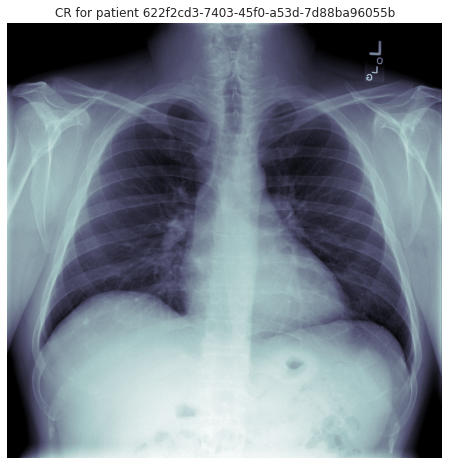


Displaying information for patient 15f05b19-3673-46a4-8a55-1952d4e2b829
File                : /kaggle/input/pneumothorax/train/dicom_files/1.2.276.0.7230010.3.1.4.8323329.3340.1517875177.340788.dcm

Id                  : 15f05b19-3673-46a4-8a55-1952d4e2b829
Age                 : 57
Sex                 : F
Modality            : CR
Body Part           : CHEST
View Position       : PA
Image size          : 1024 x 1024



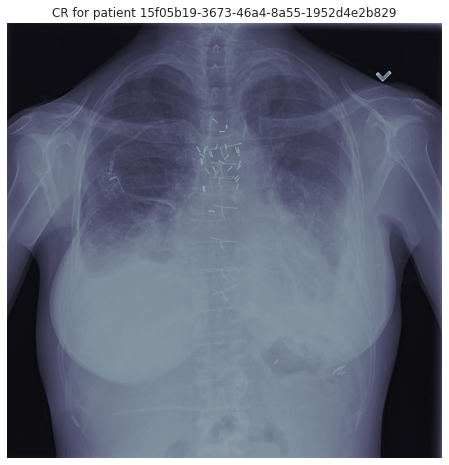


Displaying information for patient b0bc9545-e930-4390-a294-3b256a4c28dc
File                : /kaggle/input/pneumothorax/train/dicom_files/1.2.276.0.7230010.3.1.4.8323329.32568.1517875161.247855.dcm

Id                  : b0bc9545-e930-4390-a294-3b256a4c28dc
Age                 : 52
Sex                 : F
Modality            : CR
Body Part           : CHEST
View Position       : AP
Image size          : 1024 x 1024



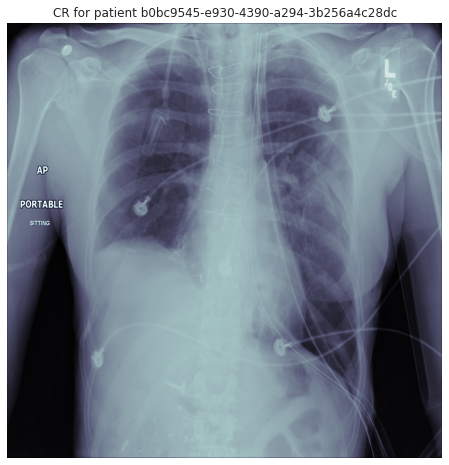

In [5]:
random.seed(1)
samples = random.sample(glob.glob('/kaggle/input/pneumothorax/train/dicom_files/*'), 3)

for file_path in samples:
    sample = pydicom.dcmread(file_path)
    print_dcm(sample)
    plot_pixel_array(sample)

We have just printed a few fields from the dicom metadata fields such as the patient ID, its age and sex. We can also see that all the samples seem to be CR scans of the chest with a size of 1024 by 1024.

We can also observe the is some text or other kind of artifacts (or medical equipment) that is visible in the images and that we bust be aware of during training.

Let's now visualize other samples with their respective masks. For this we will simply use the first n samples from the training dataset csv, so let's explore how this csv also looks like.

In [6]:
train = pd.read_csv("/kaggle/input/pneumothorax/train/train-rle.csv")
train.head()

,ImageId,EncodedPixels
0,1.2.276.0.7230010.3.1.4.8323329.5597.151787518...,-1
1,1.2.276.0.7230010.3.1.4.8323329.12515.15178752...,-1
2,1.2.276.0.7230010.3.1.4.8323329.4904.151787518...,175349 7 1013 12 1009 17 1005 19 1003 20 1002...
3,1.2.276.0.7230010.3.1.4.8323329.32579.15178751...,407576 2 1021 7 1015 10 1013 12 1011 14 1008 ...
4,1.2.276.0.7230010.3.1.4.8323329.32579.15178751...,252069 1 1021 3 1020 4 1018 5 1018 6 1016 7 1...


We can see it has two columns. The first one containing the image id that is also the name of input files and the EncodedPixels field. This second one contains a -1 if there is no pneumothorax to be segmented in the image, or the segmentation mask if there is indeed pneumothorax in the sample.

In [7]:
def rle2mask(rle, width, height):
    '''
    RLE to mask conversion as given.
    It inputs the rle (EncodedPixel value) and return the mask value.
    '''
    mask= np.zeros(width* height)
    array = np.asarray([int(x) for x in rle.split()])
    starts = array[0::2]
    lengths = array[1::2]

    current_position = 0
    for index, start in enumerate(starts):
        current_position += start
        mask[current_position:current_position+lengths[index]] = 1
        current_position += lengths[index]

    return mask.reshape(width, height).T

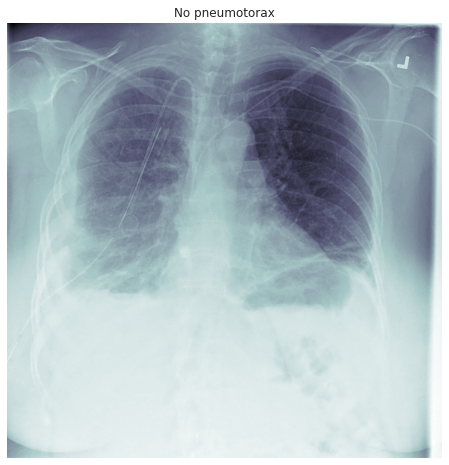

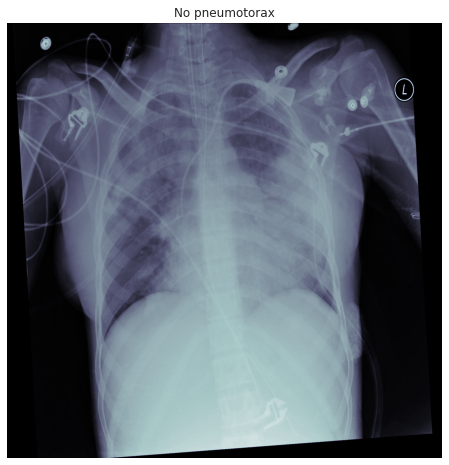

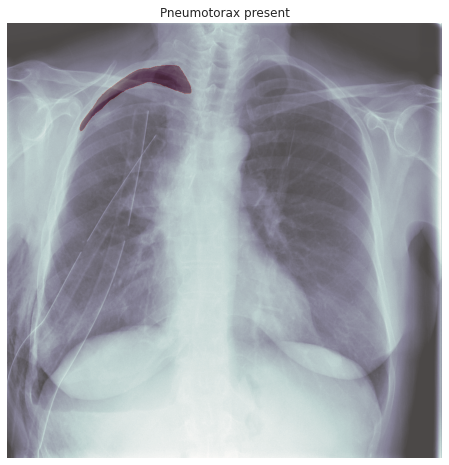

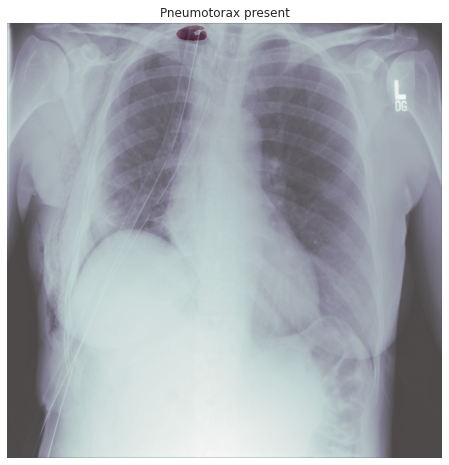

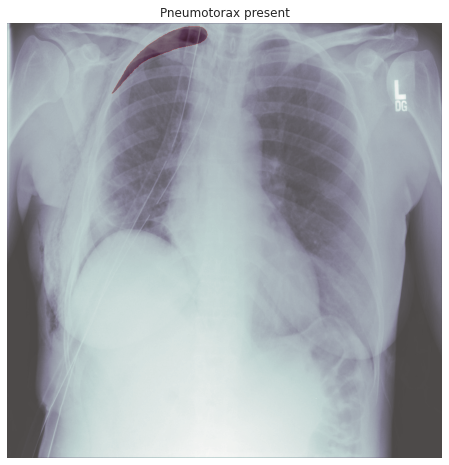

In [8]:
#fig, ax = plt.subplots(nrows=1, ncols=n_imgs, sharey=True, figsize=(20,5))
n_imgs = 5
root = "/kaggle/input/pneumothorax/train/dicom_files/"
for i in range(n_imgs):
    f_id = train["ImageId"][i]
    sample = pydicom.dcmread(f"{root}{f_id}.dcm")
    if train[" EncodedPixels"][i] == ' -1':
        plot_pixel_array(sample, title="No pneumotorax")
    else:
        plt.figure(figsize=(8,8))
        plt.imshow(sample.pixel_array, cmap=plt.cm.bone)
        mask = rle2mask(train[" EncodedPixels"][i][1:], sample.Rows, sample.Columns) * 255
        plt.imshow(mask, alpha=0.3, cmap="Reds")
        plt.axis("off")
        plt.title("Pneumotorax present")
        plt.show()

## 3. Implementation and results
In this section we implement 3 different approaches:
* Unet
* Xception Unet
* Xception Unet with data augmentation

The first one is one of the most simple segmentation solutions we can use and it will be implemented to explore how far it could go with this dataset. The last two ones are based on other participants of the contest who achieved good results using such architecture. We want to see how better results we can get compared to the base unet.

### 3.0 Utilities
In this first section we implement some utilities that will be usefull for the implementations tried in the notebook

In [9]:
im_height = 1024
im_width = 1024
target_height = 256
target_width = 256
im_chan = 1

def get_data(files_path, train_df):
    # Get train images and masks
    X_train = np.zeros((len(files_path), target_height, target_width, im_chan), dtype=np.uint8)
    Y_train = np.zeros((len(files_path), target_height, target_width, 1), dtype=bool)
    print('Getting train images and masks ... ')
    sys.stdout.flush()
    for n, _id in tqdm(enumerate(files_path), total=len(files_path)):
        dataset = pydicom.read_file(_id)
        img =  np.expand_dims(dataset.pixel_array, axis=2)
        X_train[n] = cv2.resize(img, (target_height, target_width))[..., np.newaxis]
        try:
            if '-1' in train_df.loc[_id.split('/')[-1][:-4],' EncodedPixels']:
                Y_train[n] = np.zeros((target_height, target_width, 1))
            else:
                if type(train_df.loc[_id.split('/')[-1][:-4],' EncodedPixels']) == str:
                    mask =  np.expand_dims(rle2mask(train_df.loc[_id.split('/')[-1][:-4],' EncodedPixels'], 1024, 1024), axis=2)
                    Y_train[n] = cv2.resize(mask, (target_height, target_width))[..., np.newaxis]
                else:
                    mask = np.zeros((1024, 1024, 1))
                    for x in train_df.loc[_id.split('/')[-1][:-4],' EncodedPixels']:
                        mask =  mask + np.expand_dims(rle2mask(x, 1024, 1024), axis=2)
                    Y_train[n] = cv2.resize(mask, (target_height, target_width))[..., np.newaxis]
        except KeyError:
            print(f"Key {_id.split('/')[-1][:-4]} without mask, assuming healthy patient.")
            Y_train[n] = np.zeros((target_height, target_width, 1)) # Assume missing masks are empty masks.

    print('Done!')
    return X_train, Y_train

As seen in the previous cell, we used the csv file to load all the training data. This is used in the first approach implementation. The images are retrieved from the dicom file and the masks are generated from the dataset csv. For that we use the rle2mask utility for those samples that have a mask or set everything to 0 when there is no pneumothorax (and thus no mask) in a sample.

In [10]:
def shuffle_and_split_data(imgs, masks, val_split=0.1, test_split=0.1):
    """
    Shuffle and split data into train, val and test datasets.
    """
    
    tmp = list(zip(imgs, masks))
    random.shuffle(tmp)
    imgs, masks = zip(*tmp)
    imgs, masks = list(imgs), list(masks)
    val_idx = int(len(imgs)*(val_split + test_split))
    test_idx = int(len(imgs)*test_split)
    
    return imgs[val_idx:], masks[val_idx:], imgs[test_idx:val_idx], masks[test_idx:val_idx], imgs[:test_idx], masks[:test_idx]

For the second approach we instad use directly the png files for both the chest image and the mask groundtruth. Since the dataset does not include validation splits and the test masks are all empty (no available gt), we will be just splitting the train images (10k) into training, validation and test sets. We will use the previously defined function that will shuffle all the files and separate it into three sets accordingly to the test and val split ratios.

In [11]:
def dice_coefficient(y_true, y_pred):
    # Flatten the data
    y_true_flat = K.flatten(y_true)
    y_pred_flat = K.flatten(y_pred)
    
    y_pred = K.cast(y_pred_flat, 'float32')
    y_pred_f = K.cast(K.greater(y_pred, 0.3), 'float32')

    # Calculate the intersection of the two sets
    # intersection = K.sum(y_true_flat * y_pred_flat)
    intersection = K.sum(y_true_flat * y_pred_f)

    # Calculate the union of the two sets
    union = K.sum(y_true_flat) + K.sum(y_pred_f)

    # Handle empty masks
    if union == 0:
        return 1.

    # Calculate and return the Dice coefficient
    dice = 2. * intersection / union
    return dice

def dice_loss(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = y_true_f * y_pred_f
    score = (2. * K.sum(intersection) + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return 1. - score

def bce_dice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)

def bce_logdice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) - K.log(1. - dice_loss(y_true, y_pred))

We also define here the main metric we will use to evaluate and monitor our models: Dice Coefficient. This version of the function is adapted to be attached as a custom metric function in the Keras ecosystem. It will perform operation within the tensors used in the trainin/evaluation process. We also define its equivalent to loss function dice_loss that will be used by both the binary crossentropy dice loss extension and the binary crossentropy log dice loss extension.

In [12]:
def convolution_block(x, filters, size, strides=(1,1), padding='same', activation=True):
    x = Conv2D(filters, size, strides=strides, padding=padding)(x)
    x = BatchNormalization()(x)
    if activation == True:
        x = LeakyReLU(alpha=0.1)(x)
    return x

def residual_block(blockInput, num_filters=16):
    x = LeakyReLU(alpha=0.1)(blockInput)
    x = BatchNormalization()(x)
    blockInput = BatchNormalization()(blockInput)
    x = convolution_block(x, num_filters, (3,3) )
    x = convolution_block(x, num_filters, (3,3), activation=False)
    x = Add()([x, blockInput])
    return x

We add some layering helpers to reduce the amount of code when defining more complex networks

In [13]:
def plot_history(history):
    # Visualize training history

    plt.figure(figsize=(15,8))
    plt.plot(history.history['dice_coefficient'])
    plt.plot(history.history['val_dice_coefficient'])
    plt.title('Model dice coefficient', size=20)
    plt.ylabel('Dice coefficient', size=15)
    plt.xlabel('Epoch', size=15)
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

    plt.figure(figsize=(15,8))
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss', size=20)
    plt.ylabel('Loss', size=15)
    plt.xlabel('Epoch', size=15)
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

### 3.1 First implementation: base Unet
As a first approach we will be defining a basic Unet to tackle the problem of the challenge. We first define a way of loading the training data. Then some auxiliary functions that will be helpful (more comments on those along the code) and finally the Unet model. We train it and explore some results.

In [14]:
# Create training and test dataset from the csv file
train_files = sorted(glob.glob('/kaggle/input/pneumothorax/train/dicom_files/*'))
test_files = sorted(glob.glob('/kaggle/input/pneumothorax/test/dicom_files/*'))
train_df = pd.read_csv('/kaggle/input/pneumothorax/train/train-rle.csv', index_col='ImageId')
X_train, Y_train = get_data(train_files, train_df)

Getting train images and masks ... 


  0%|          | 0/50 [00:00<?, ?it/s]

Done!


We now explore again some samples with the new way of loading the dataset just to make sure everything is stored as expected.

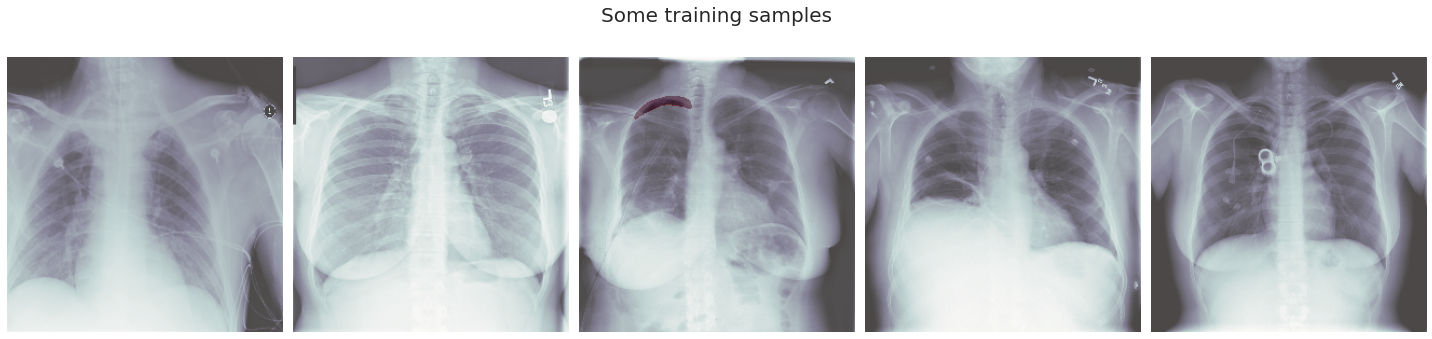

In [15]:
n_imgs = 5
fig, ax = plt.subplots(nrows=1, ncols=n_imgs, sharey=True, figsize=(20,5))
for i in range(n_imgs):
    ax[i].imshow(X_train[i+4], cmap=plt.cm.bone)
    ax[i].imshow(Y_train[i+4], cmap="Reds", alpha=0.3)
    ax[i].axis("off")
plt.suptitle("Some training samples", size=20)
plt.tight_layout()
plt.show()

We now define the metric to track during training: dice coefficient. It is based in the Intersection over Union metric that computes a ratio of common equal predictions vs total values among the prediction and groundtruth.

At this point we define the Unet architecture

In [16]:
def UNet(input_shape=(None, None, 1)):

    inputs = Input(input_shape)

    c1 = Conv2D(8, (3, 3), activation='relu', padding='same') (inputs)
    c1 = Conv2D(8, (3, 3), activation='relu', padding='same') (c1)
    p1 = MaxPooling2D((2, 2)) (c1)

    c2 = Conv2D(16, (3, 3), activation='relu', padding='same') (p1)
    c2 = Conv2D(16, (3, 3), activation='relu', padding='same') (c2)
    p2 = MaxPooling2D((2, 2)) (c2)

    c3 = Conv2D(32, (3, 3), activation='relu', padding='same') (p2)
    c3 = Conv2D(32, (3, 3), activation='relu', padding='same') (c3)
    p3 = MaxPooling2D((2, 2)) (c3)

    c4 = Conv2D(64, (3, 3), activation='relu', padding='same') (p3)
    c4 = Conv2D(64, (3, 3), activation='relu', padding='same') (c4)
    p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

    c5 = Conv2D(64, (3, 3), activation='relu', padding='same') (p4)
    c5 = Conv2D(64, (3, 3), activation='relu', padding='same') (c5)
    p5 = MaxPooling2D(pool_size=(2, 2)) (c5)

    c55 = Conv2D(128, (3, 3), activation='relu', padding='same') (p5)
    c55 = Conv2D(128, (3, 3), activation='relu', padding='same') (c55)

    u6 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c55)
    u6 = concatenate([u6, c5])
    c6 = Conv2D(64, (3, 3), activation='relu', padding='same') (u6)
    c6 = Conv2D(64, (3, 3), activation='relu', padding='same') (c6)

    u71 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c6)
    u71 = concatenate([u71, c4])
    c71 = Conv2D(32, (3, 3), activation='relu', padding='same') (u71)
    c61 = Conv2D(32, (3, 3), activation='relu', padding='same') (c71)

    u7 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c61)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(32, (3, 3), activation='relu', padding='same') (u7)
    c7 = Conv2D(32, (3, 3), activation='relu', padding='same') (c7)

    u8 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(16, (3, 3), activation='relu', padding='same') (u8)
    c8 = Conv2D(16, (3, 3), activation='relu', padding='same') (c8)

    u9 = Conv2DTranspose(8, (2, 2), strides=(2, 2), padding='same') (c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(8, (3, 3), activation='relu', padding='same') (u9)
    c9 = Conv2D(8, (3, 3), activation='relu', padding='same') (c9)

    outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

    model = Model(inputs=[inputs], outputs=[outputs])
    
    return model

2022-12-26 11:31:37.936052: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-26 11:31:38.062056: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-26 11:31:38.063260: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-26 11:31:38.064666: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Epoch 1/30


2022-12-26 11:31:43.792212: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


2/2 [==============================] - 11s 1s/step - loss: 0.5483 - dice_coefficient: 0.0048 - val_loss: 0.3663 - val_dice_coefficient: 0.0013
Epoch 2/30
2/2 [==============================] - 0s 48ms/step - loss: 0.3478 - dice_coefficient: 0.0089 - val_loss: 0.1924 - val_dice_coefficient: 8.9880e-04
Epoch 3/30
2/2 [==============================] - 0s 60ms/step - loss: 0.1819 - dice_coefficient: 0.0034 - val_loss: 0.1019 - val_dice_coefficient: 7.0590e-04
Epoch 4/30
2/2 [==============================] - 0s 49ms/step - loss: 0.1080 - dice_coefficient: 2.7948e-04 - val_loss: 0.0699 - val_dice_coefficient: 3.9683e-04
Epoch 5/30
2/2 [==============================] - 0s 48ms/step - loss: 0.0867 - dice_coefficient: 0.0000e+00 - val_loss: 0.0536 - val_dice_coefficient: 2.5944e-04
Epoch 6/30
2/2 [==============================] - 0s 47ms/step - loss: 0.0779 - dice_coefficient: 0.0000e+00 - val_loss: 0.0450 - val_dice_coefficient: 0.0000e+00
Epoch 7/30
2/2 [==============================] - 

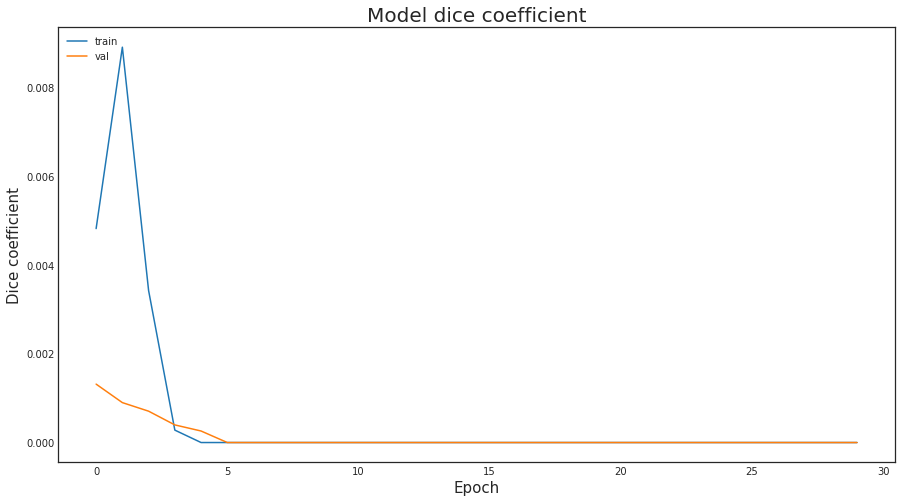

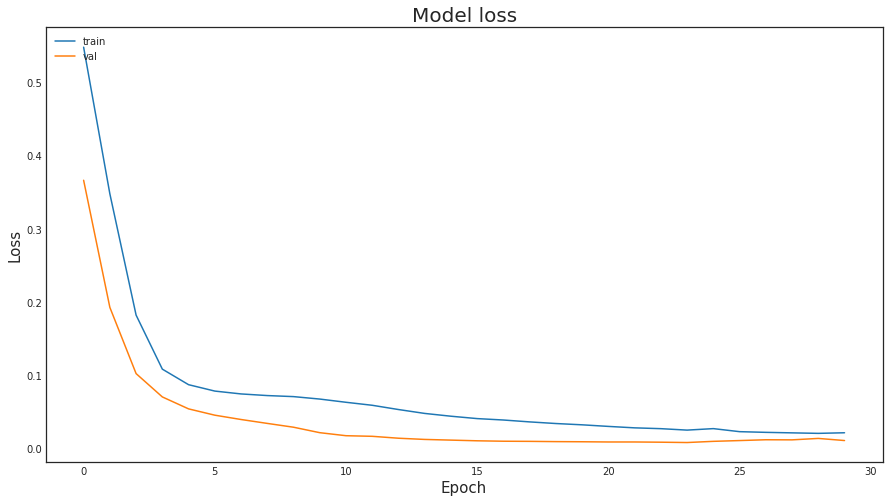

In [17]:
# Training with the first approach for the data
img_size = 256
epochs = 30

model = UNet(input_shape=(img_size, img_size, 1))
metrics = [dice_coefficient]
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=metrics)

history = model.fit(X_train, Y_train, validation_split=.2, batch_size=32, epochs=epochs)

plot_history(history)

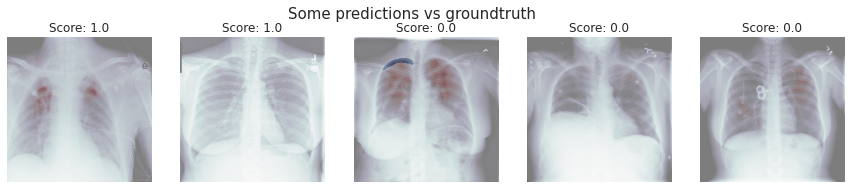

In [18]:
offset = 4
max_imgs = 5
predictions = model.predict(X_train[offset:max_imgs+offset])
fig, axs = plt.subplots(1, max_imgs, figsize=(max_imgs*3, 1*3))
for i in range(0,max_imgs):
    axs[i].imshow(X_train[offset + i], cmap=plt.cm.bone)
    axs[i].imshow(predictions[i], alpha=0.3, cmap="Reds")
    axs[i].imshow(Y_train[offset + i], alpha=0.3, cmap="Blues")
    score = dice_coefficient(K.cast(Y_train[offset + i], "float32"), predictions[i])
    axs[i].set_title(f"Score: {score:.4}")
    axs[i].axis("off")
plt.suptitle("Some predictions vs groundtruth", size=15)
plt.show()

### Implementation 2

In [38]:
h, w, batch_size = 256,256,16
val_split = 0.1
test_split = 0.1
im_paths = f'/kaggle/input/pneumothorax/train/images/{h}/dicom/'
mask_paths = f'/kaggle/input/pneumothorax/train/images/{h}/mask/'
all_ims = glob.glob(im_paths+'/*')
all_masks = glob.glob(mask_paths+'/*')

train_im_path, train_mask_path, val_im_path, val_mask_path, test_im_path, test_mask_path = shuffle_and_split_data(all_ims, all_masks, val_split=val_split, test_split=test_split)

print("Total training images: ", len(train_im_path))
print("Total validation images: ", len(val_im_path))
print("Total test images: ", len(test_im_path))

Total training images:  8570
Total validation images:  1071
Total test images:  1071


In [20]:
class DataGenerator(tf.keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, train_im_path=train_im_path,train_mask_path=train_mask_path, im_path=im_paths, mask_path=mask_paths,
                 augmentations=None, batch_size=batch_size,img_size=256, n_channels=3, shuffle=True):
        'Initialization'
        self.batch_size = batch_size
        self.train_im_paths = train_im_path
        
        self.train_im_path = im_path
        self.train_mask_path = mask_path

        self.img_size = img_size
        
        self.n_channels = n_channels
        self.shuffle = shuffle
        self.augment = augmentations
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.ceil(len(self.train_im_paths) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:min((index+1)*self.batch_size,len(self.train_im_paths))]

        # Find list of IDs
        list_IDs_im = [self.train_im_paths[k] for k in indexes]

        # Generate data
        X, y = self.data_generation(list_IDs_im)

        if self.augment is None:
            return X,np.array(y)/255
        else:            
            im,mask = [],[]   
            for x,y in zip(X,y):
                augmented = self.augment(image=x, mask=y)
                im.append(augmented['image'])
                mask.append(augmented['mask'])
            return np.array(im),np.array(mask)/255

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.train_im_paths))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def data_generation(self, list_IDs_im):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.empty((len(list_IDs_im),self.img_size,self.img_size, self.n_channels))
        y = np.empty((len(list_IDs_im),self.img_size,self.img_size, 1))

        # Generate data
        for i, im_path in enumerate(list_IDs_im):
            
            im = np.array(Image.open(im_path))
            mask_path = im_path.replace(self.train_im_path, self.train_mask_path)
            
            mask = np.array(Image.open(mask_path))
            
            
            if len(im.shape)==2:
                im = np.repeat(im[...,None],3,2)

            # Resize sample
            X[i,] = cv2.resize(im,(self.img_size,self.img_size))

            # Store class
            y[i,] = cv2.resize(mask,(self.img_size,self.img_size))[..., np.newaxis]
            y[y>0] = 255

        return np.uint8(X),np.uint8(y)

Testing the data generator. Visualizing again some samples, this time with masks too.

In [21]:
dummy_dataset = DataGenerator(batch_size=16,shuffle=False)

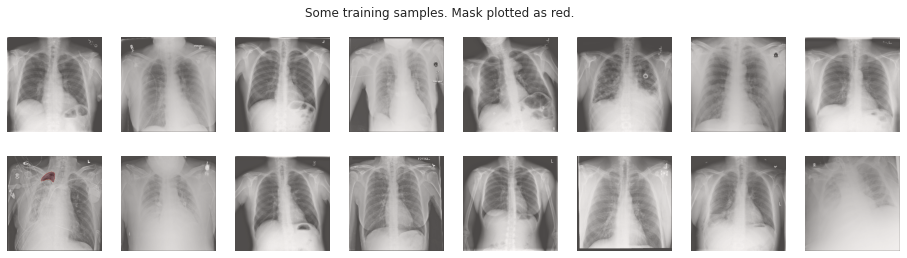

In [22]:
images, masks = dummy_dataset.__getitem__(1)
max_images = 16
grid_width = 8
grid_height = max_images // grid_width
fig, axs = plt.subplots(grid_height, grid_width, figsize=(grid_width*2, grid_height*2))

for i,(im, mask) in enumerate(zip(images, masks)):
    ax = axs[i // grid_width, i % grid_width]
    ax.imshow(im, cmap=plt.cm.bone)
    ax.imshow(mask, alpha=0.3, cmap="Reds")    
    ax.axis('off')
plt.suptitle("Some training samples. Mask plotted as red.")
plt.show()

As we can see, data is properly loaded into the data generator.

In [23]:
def UXception(input_shape=(None, None, 3),dropout_rate=0.5):

    backbone = Xception(input_shape=input_shape,weights='imagenet',include_top=False)
    input = backbone.input
    start_neurons = 16

    conv4 = backbone.layers[121].output
    conv4 = LeakyReLU(alpha=0.1)(conv4)
    pool4 = MaxPooling2D((2, 2))(conv4)
    pool4 = Dropout(dropout_rate)(pool4)
    
     # Middle
    convm = Conv2D(start_neurons * 32, (3, 3), activation=None, padding="same")(pool4)
    convm = residual_block(convm,start_neurons * 32)
    convm = residual_block(convm,start_neurons * 32)
    convm = LeakyReLU(alpha=0.1)(convm)
    
    deconv4 = Conv2DTranspose(start_neurons * 16, (3, 3), strides=(2, 2), padding="same")(convm)
    uconv4 = concatenate([deconv4, conv4])
    uconv4 = Dropout(dropout_rate)(uconv4)
    
    uconv4 = Conv2D(start_neurons * 16, (3, 3), activation=None, padding="same")(uconv4)
    uconv4 = residual_block(uconv4,start_neurons * 16)
    uconv4 = residual_block(uconv4,start_neurons * 16)
    uconv4 = LeakyReLU(alpha=0.1)(uconv4)
    
    deconv3 = Conv2DTranspose(start_neurons * 8, (3, 3), strides=(2, 2), padding="same")(uconv4)
    conv3 = backbone.layers[31].output
    uconv3 = concatenate([deconv3, conv3])    
    uconv3 = Dropout(dropout_rate)(uconv3)
    
    uconv3 = Conv2D(start_neurons * 8, (3, 3), activation=None, padding="same")(uconv3)
    uconv3 = residual_block(uconv3,start_neurons * 8)
    uconv3 = residual_block(uconv3,start_neurons * 8)
    uconv3 = LeakyReLU(alpha=0.1)(uconv3)

    deconv2 = Conv2DTranspose(start_neurons * 4, (3, 3), strides=(2, 2), padding="same")(uconv3)
    conv2 = backbone.layers[21].output
    conv2 = ZeroPadding2D(((1,0),(1,0)))(conv2)
    uconv2 = concatenate([deconv2, conv2])
        
    uconv2 = Dropout(0.1)(uconv2)
    uconv2 = Conv2D(start_neurons * 4, (3, 3), activation=None, padding="same")(uconv2)
    uconv2 = residual_block(uconv2,start_neurons * 4)
    uconv2 = residual_block(uconv2,start_neurons * 4)
    uconv2 = LeakyReLU(alpha=0.1)(uconv2)
    
    deconv1 = Conv2DTranspose(start_neurons * 2, (3, 3), strides=(2, 2), padding="same")(uconv2)
    conv1 = backbone.layers[11].output
    conv1 = ZeroPadding2D(((3,0),(3,0)))(conv1)
    uconv1 = concatenate([deconv1, conv1])
    
    uconv1 = Dropout(0.1)(uconv1)
    uconv1 = Conv2D(start_neurons * 2, (3, 3), activation=None, padding="same")(uconv1)
    uconv1 = residual_block(uconv1,start_neurons * 2)
    uconv1 = residual_block(uconv1,start_neurons * 2)
    uconv1 = LeakyReLU(alpha=0.1)(uconv1)
    
    uconv0 = Conv2DTranspose(start_neurons * 1, (3, 3), strides=(2, 2), padding="same")(uconv1)   
    uconv0 = Dropout(dropout_rate)(uconv0)
    uconv0 = Conv2D(start_neurons * 1, (3, 3), activation=None, padding="same")(uconv0)
    uconv0 = residual_block(uconv0,start_neurons * 1)
    uconv0 = residual_block(uconv0,start_neurons * 1)
    uconv0 = LeakyReLU(alpha=0.1)(uconv0)
    
    uconv0 = Dropout(dropout_rate/2)(uconv0)
    output_layer = Conv2D(1, (1,1), padding="same", activation="sigmoid")(uconv0)    
    
    model = Model(input, output_layer)

    return model

# TODO: rearange this

Epoch 1/5
3/3 - 4s - loss: 13.4421 - dice_coefficient: 0.0018 - val_loss: 1.9743 - val_dice_coefficient: 0.0225
Epoch 2/5
3/3 - 0s - loss: 1.4958 - dice_coefficient: 0.0019 - val_loss: 1.1698 - val_dice_coefficient: 1.0528e-04
Epoch 3/5
3/3 - 0s - loss: 1.0561 - dice_coefficient: 0.0000e+00 - val_loss: 1.2105 - val_dice_coefficient: 0.0000e+00
Epoch 4/5
3/3 - 0s - loss: 1.0364 - dice_coefficient: 0.0000e+00 - val_loss: 1.2601 - val_dice_coefficient: 0.0000e+00
Epoch 5/5
3/3 - 0s - loss: 1.0328 - dice_coefficient: 0.0000e+00 - val_loss: 1.3348 - val_dice_coefficient: 0.0000e+00


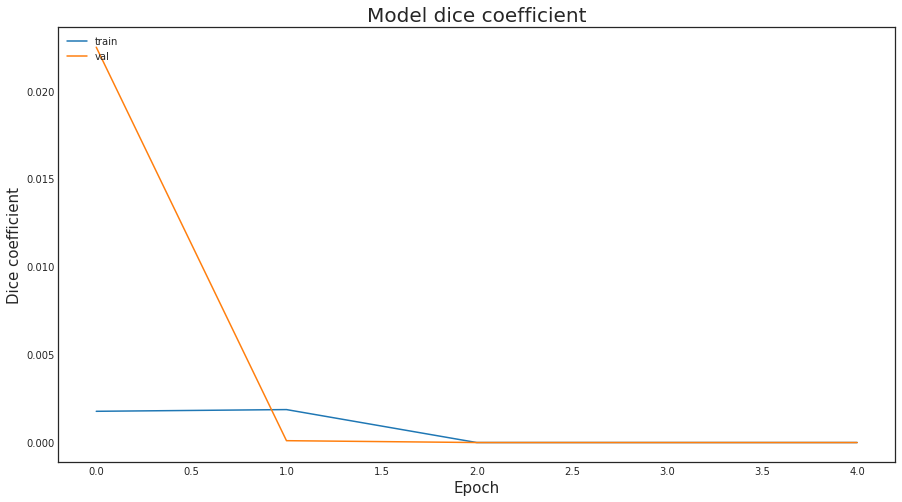

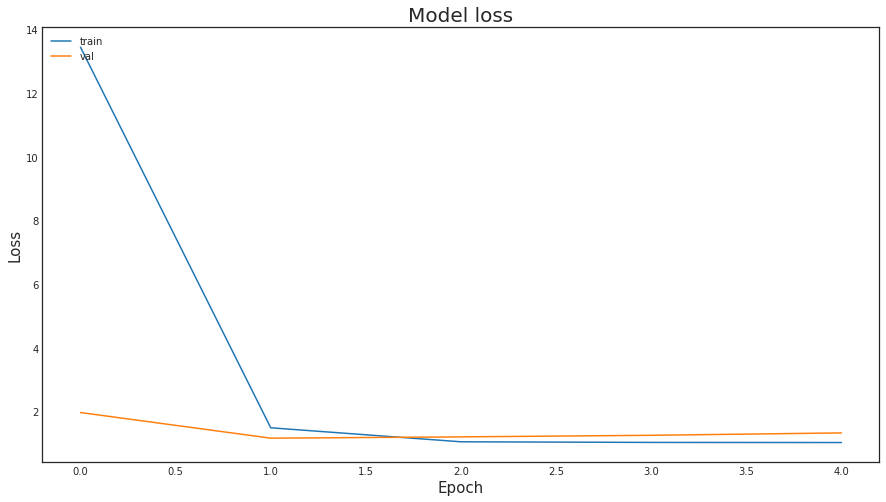

In [24]:
# Using dataloader

epochs = 30
batch_size = 16

# Generators
training_generator = DataGenerator(img_size=256)
validation_generator = DataGenerator(train_im_path=val_im_path, train_mask_path=val_mask_path,
                                     img_size=256)


K.clear_session()

model = UNet(input_shape=(img_size,img_size,3))

model.compile(optimizer='adam', loss=bce_dice_loss, metrics=metrics)

history = model.fit(x=training_generator,
                    validation_data=validation_generator,
                    epochs=epochs,
                    verbose=2)

plot_history(history)

In [25]:
K.clear_session()
img_size = 256
model = UXception(input_shape=(img_size,img_size,3),dropout_rate=0.5)

83697664/83683744 [==============================] - 0s 0us/step


In [26]:
class SnapshotCallbackBuilder:
    def __init__(self, nb_epochs, nb_snapshots, init_lr=0.1):
        self.T = nb_epochs
        self.M = nb_snapshots
        self.alpha_zero = init_lr

    def get_callbacks(self, model_prefix='Model'):

        callback_list = [
            callbacks.ModelCheckpoint("./keras.model", monitor='val_dice_coefficient', 
                                   mode = 'max', save_best_only=True, verbose=1),
            callbacks.LearningRateScheduler(schedule=self._cosine_anneal_schedule)
        ]

        return callback_list

    def _cosine_anneal_schedule(self, t):
        cos_inner = np.pi * (t % (self.T // self.M))  # t - 1 is used when t has 1-based indexing.
        cos_inner /= self.T // self.M
        cos_out = np.cos(cos_inner) + 1
        return float(self.alpha_zero / 2 * cos_out)

In [27]:
metrics = [dice_coefficient]
model.compile(loss=bce_dice_loss, optimizer='adam', metrics=metrics)

Epoch 1/3
3/3 - 14s - loss: 1.2976 - dice_coefficient: 0.0021 - val_loss: 1.2245 - val_dice_coefficient: 0.0000e+00

Epoch 00001: val_dice_coefficient improved from -inf to 0.00000, saving model to ./keras.model


2022-12-26 11:32:38.203737: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/3
3/3 - 1s - loss: 1.2096 - dice_coefficient: 0.0021 - val_loss: 1.2467 - val_dice_coefficient: 0.0000e+00

Epoch 00002: val_dice_coefficient did not improve from 0.00000
Epoch 3/3
3/3 - 1s - loss: 1.1591 - dice_coefficient: 0.0019 - val_loss: 1.2208 - val_dice_coefficient: 0.0000e+00

Epoch 00003: val_dice_coefficient did not improve from 0.00000


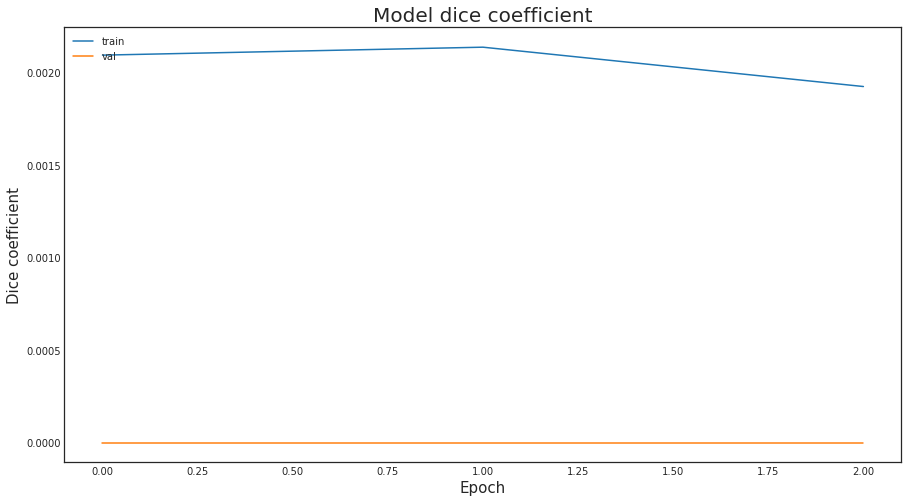

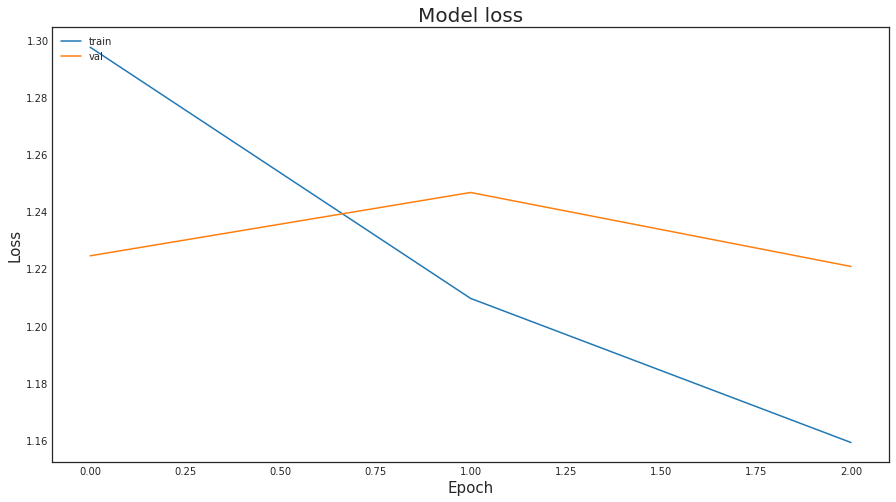

In [28]:
epochs = 30
snapshot = SnapshotCallbackBuilder(nb_epochs=epochs, nb_snapshots=1, init_lr=1e-3)
batch_size = 16

# Generators
training_generator = DataGenerator(img_size=256)
validation_generator = DataGenerator(train_im_path=val_im_path, train_mask_path=val_mask_path,
                                     img_size=256)

history = model.fit(x=training_generator,
                    validation_data=validation_generator,
                    epochs=epochs,
                    verbose=2,
                    callbacks=snapshot.get_callbacks())

plot_history(history)

In [29]:
test_generator = DataGenerator(train_im_path=test_im_path, train_mask_path=test_mask_path, img_size=256, batch_size=1)
pred = model.predict(test_generator)
score = model.evaluate(test_generator)

5/5 [==============================] - 0s 21ms/step - loss: 1.0664 - dice_coefficient: 0.0000e+00


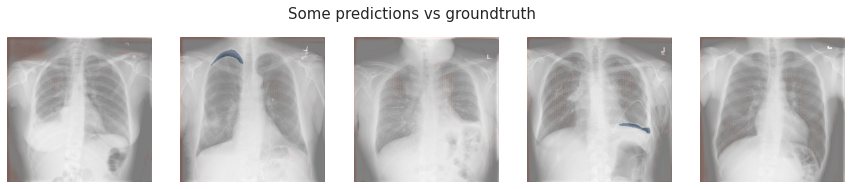

In [30]:
max_imgs = 5
fig, axs = plt.subplots(1, max_imgs, figsize=(max_imgs*3, 1*3))
for i in range(0,max_imgs):
    test_img, test_mask = test_generator.__getitem__(i)
    axs[i].imshow(test_img[0], cmap=plt.cm.bone)
    axs[i].imshow(pred[i], alpha=0.3, cmap="Reds")
    axs[i].imshow(test_mask[0], alpha=0.3, cmap="Blues")
    axs[i].axis("off")
plt.suptitle("Some predictions vs groundtruth", size=15)
plt.show()

### 3.3 Xception Unet with data augmentation
For the last experiment we will explore the impact of using data augmentation techniques.
We start by defining different transformations for both testing and training data.

In [31]:
import cv2
from albumentations import (
    Compose, HorizontalFlip, CLAHE, HueSaturationValue,
    RandomBrightnessContrast, RandomGamma,OneOf,
    ToFloat, ShiftScaleRotate,GridDistortion, ElasticTransform, JpegCompression, HueSaturationValue,
    RGBShift, RandomBrightness, RandomContrast, Blur, MotionBlur, MedianBlur, GaussNoise,CenterCrop,
    IAAAdditiveGaussianNoise,GaussNoise,OpticalDistortion,RandomSizedCrop
)

train_augmentations = Compose([
    HorizontalFlip(p=0.5),
    OneOf([
        RandomBrightnessContrast(),
        RandomGamma(),
         ], p=0.3),
    OneOf([
        ElasticTransform(alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03),
        GridDistortion(),
        OpticalDistortion(distort_limit=2, shift_limit=0.5),
        ], p=0.3),
    RandomSizedCrop(min_max_height=(160, 256), height=h, width=w,p=0.25),
],p=1)

Let's explore how the data looks now after the transformations

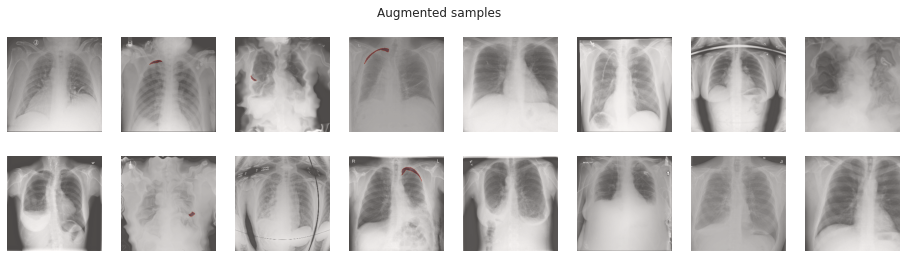

In [32]:
dummy_dataset_augm = DataGenerator(batch_size=16,augmentations=train_augmentations,shuffle=False)

images, masks = dummy_dataset_augm.__getitem__(0)
max_images = 16
grid_width = 8
grid_height = max_images // grid_width
fig, axs = plt.subplots(grid_height, grid_width, figsize=(grid_width*2, grid_height*2))

for i,(im, mask) in enumerate(zip(images, masks)):
    ax = axs[i // grid_width, i % grid_width]
    ax.imshow(im, cmap=plt.cm.bone)
    ax.imshow(mask, alpha=0.3, cmap="Reds")    
    ax.axis('off')
plt.suptitle("Augmented samples")
plt.show()

Let's define the new training, validation and test datasets with the data augmentation activated.

In [33]:
training_generator = DataGenerator(img_size=256, augmentations=train_augmentations)
validation_generator = DataGenerator(train_im_path=val_im_path, train_mask_path=val_mask_path,
                                     img_size=256)

Let's redefine the training environment.

In [34]:
K.clear_session()
img_size = 256
model = UXception(input_shape=(img_size,img_size,3),dropout_rate=0.5)
metrics = [dice_coefficient]
model.compile(loss=bce_dice_loss, optimizer='adam', metrics=metrics)

Epoch 1/3
3/3 - 13s - loss: 1.7203 - dice_coefficient: 0.0020 - val_loss: 10.7447 - val_dice_coefficient: 0.0214

Epoch 00001: val_dice_coefficient improved from -inf to 0.02139, saving model to ./keras.model


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/3
3/3 - 1s - loss: 1.5638 - dice_coefficient: 0.0024 - val_loss: 25.3854 - val_dice_coefficient: 0.0216

Epoch 00002: val_dice_coefficient improved from 0.02139 to 0.02160, saving model to ./keras.model


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 3/3
3/3 - 1s - loss: 1.4941 - dice_coefficient: 0.0034 - val_loss: 22.5441 - val_dice_coefficient: 0.0215

Epoch 00003: val_dice_coefficient did not improve from 0.02160


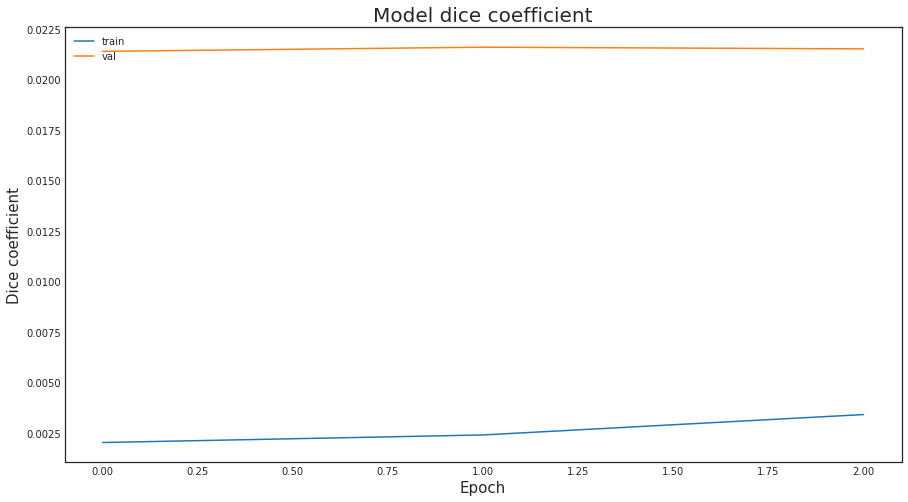

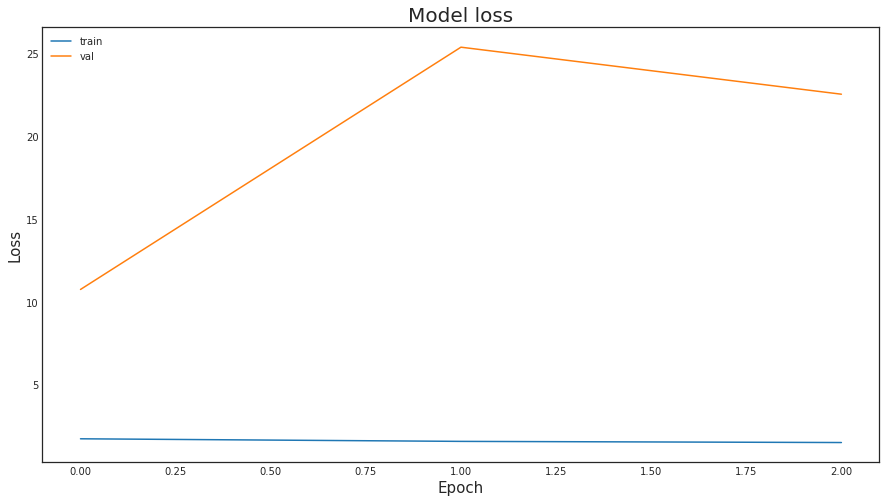

In [35]:
epochs = 30
snapshot = SnapshotCallbackBuilder(nb_epochs=epochs,nb_snapshots=1,init_lr=1e-3)
batch_size = 16

history = model.fit(x=training_generator,
                    validation_data=validation_generator,
                    epochs=epochs,
                    verbose=2,
                    callbacks=snapshot.get_callbacks())

plot_history(history)

In [36]:
test_generator = DataGenerator(train_im_path=test_im_path, train_mask_path=test_mask_path, img_size=256, batch_size=1)
pred = model.predict(test_generator)
score = model.evaluate(test_generator)

5/5 [==============================] - 0s 21ms/step - loss: 22.4207 - dice_coefficient: 0.0052


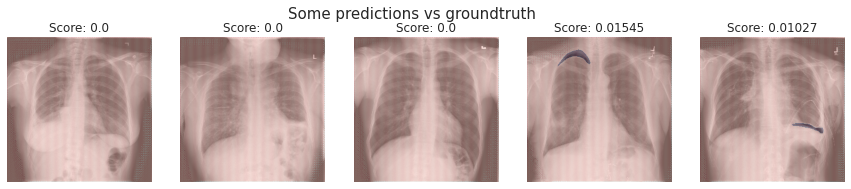

In [37]:
max_imgs = 5
fig, axs = plt.subplots(1, max_imgs, figsize=(max_imgs*3, 1*3))
for i in range(0,max_imgs):
    test_img, test_mask = test_generator.__getitem__(i)
    axs[i].imshow(test_img[0], cmap=plt.cm.bone)
    axs[i].imshow(pred[i], alpha=0.3, cmap="Reds")
    axs[i].imshow(test_mask[0], alpha=0.3, cmap="Blues")
    axs[i].axis("off")
    score = dice_coefficient(K.cast(test_mask, "float32"), pred[i])
    axs[i].set_title(f"Score: {score:.4}")

plt.suptitle("Some predictions vs groundtruth", size=15)
plt.show()

## 4. Results
TODO:
* Show training / eval curves
* Compute score in test
* Show some predictions vs groundtruth

## 5. Conclusions
write down some conclusions